In [1]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

2024-02-11 14:47:23.414026: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 14:47:23.482233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 14:47:23.482273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 14:47:23.483636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 14:47:23.495179: I tensorflow/core/platform/cpu_feature_guar

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "DATASET/d1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 399 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['a', 'aa', 'e', 'i']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 2 3 3 3 1 2 2 2 0 2 0 0 2 0 2 2 0 2 3 0 1 0 1 3 2 0 1 2 0 3]


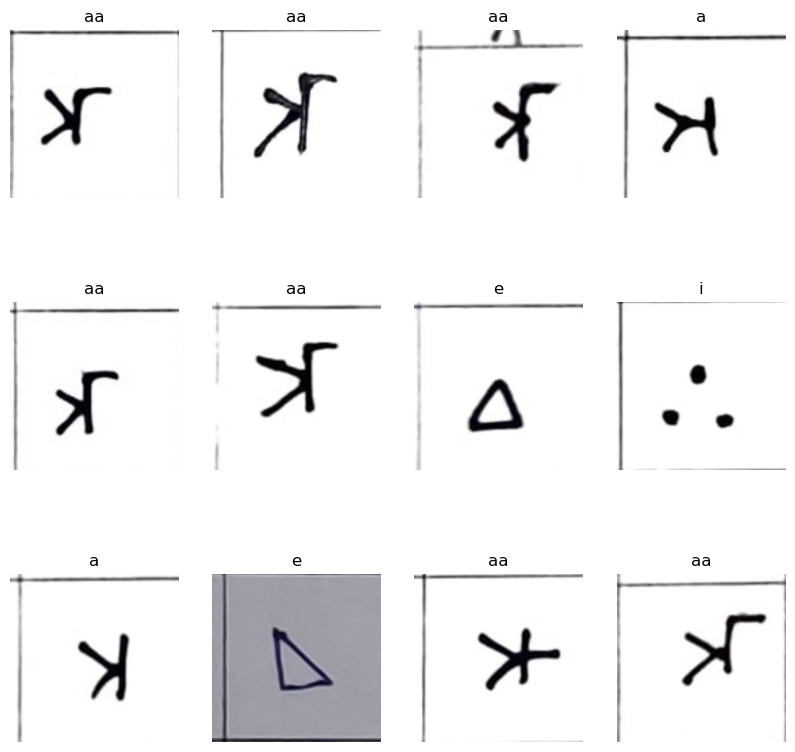

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

13

In [8]:
train_size = 0.8
len(dataset)*train_size

10.4

In [9]:
train_ds = dataset.take(188)
len(train_ds)

13

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

10

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
# Define the model architecture using MobileNet with custom top layers
mobile_net = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

for layer in mobile_net.layers:
    layer.trainable = False  # Freeze MobileNet layers

x = mobile_net.output
x = Flatten()(x)

# Adjust the number of units in the following layers according to your dataset and complexity
x = Dense(64, activation='relu')(x)  # Additional Dense layer (optional)
predictions = Dense(4, activation='softmax')(x)  # Adjust units according to num_classes

model = tf.keras.Model(inputs=mobile_net.input, outputs=predictions)

# Compile the model with appropriate loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])



TensorShape([32])

In [34]:
for images,labels in train_ds:
    print(labels_batch.shape)
    predictions = model(images)
    print(predictions.shape)

(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(32, 4)
(32,)
(15, 4)


In [ ]:
# Train the model with data augmentation
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

# Evaluate the model
model.evaluate(val_ds)

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

# Load dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "DATASET/d1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Preprocess dataset
train_ds = train_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, 4)))
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define model
mobile_net = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

for layer in mobile_net.layers:
    layer.trainable = False

x = mobile_net.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=mobile_net.input, outputs=predictions)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS
)

Found 399 files belonging to 4 classes.
Epoch 1/50
13/13 [==============================] - 8s 398ms/step - loss: 5.6344 - accuracy: 0.5363
Epoch 2/50
13/13 [==============================] - 5s 391ms/step - loss: 0.4279 - accuracy: 0.8321
Epoch 3/50
13/13 [==============================] - 5s 395ms/step - loss: 0.2209 - accuracy: 0.9524
Epoch 4/50
13/13 [==============================] - 5s 398ms/step - loss: 0.1119 - accuracy: 0.9799
Epoch 5/50
13/13 [==============================] - 5s 411ms/step - loss: 0.0774 - accuracy: 0.9724
Epoch 6/50
13/13 [==============================] - 5s 406ms/step - loss: 0.1026 - accuracy: 0.9850
Epoch 7/50
13/13 [==============================] - 5s 394ms/step - loss: 0.0237 - accuracy: 0.9925
Epoch 8/50
13/13 [==============================] - 5s 394ms/step - loss: 0.0096 - accuracy: 0.9975
Epoch 9/50
13/13 [==============================] - 5s 392ms/step - loss: 0.0046 - accuracy: 0.9975
Epoch 10/50
13/13 [==============================] - 5s 396m